# Multi Agent DDPG (MADDPG)

In [1]:
import sys
print("Python %s" % sys.version)
import os
import random, copy, time
from collections import namedtuple, deque

Python 3.7.4 (default, Aug 13 2019, 20:35:49) 
[GCC 7.3.0]


In [2]:
import numpy as np
print("NumPy %s" % np.__version__)

NumPy 1.16.5


In [3]:
import torch
print("PyTorch %s" % torch.__version__)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

PyTorch 1.2.0


In [4]:
import matplotlib
print("matplotlib %s" % matplotlib.__version__)
import matplotlib.pyplot as plt

# Set plotting options
%matplotlib inline

matplotlib 3.1.1


In [5]:
from IPython import display

In [6]:
import envs

## Hyperparameters

In [7]:
PARALLEL_ENVS = 4
BUFFER_SIZE = int(4e5)  # replay buffer size
BATCH_SIZE = 1000       # minibatch size
GAMMA = 0.95 #0.99            # discount factor
TAU = 0.02 #1e-3              # for soft update of target parameters
STATE_SIZE = 14
ACTION_SIZE = 2
SEED = 1 #2
# LR = 5e-4               # learning rate
LR_ACTOR = 1.0e-2 #1e-4         # learning rate of the actor 
LR_CRITIC = 1.0e-2 #1e-3        # l earning rate of the critic
# UPDATE_EVERY = 4        # how often to update the network
WEIGHT_DECAY = 1.0e-5 #0        # L2 weight decay
NOISE_RATE_INIT = 2.0
NOISE_RATE_REDUCTION = 0.9999
SIGMA = 0.2 #0.1             # standard deviation for noise
SCALE = 1.0             # noise scale

## Environment

Environment returns two different kind of states: states of all individual agent observations and states of full observation.

In [8]:
torch.set_num_threads(PARALLEL_ENVS)

In [9]:
env = envs.make_parallel_env(PARALLEL_ENVS)

In [10]:
env

In [11]:
env.num_envs

4

In [12]:
env.agent_types

['adversary', 'agent', 'agent']

In [13]:
env.action_space

[Box(2,), Box(2,), Box(2,)]

## Actor-Critic Models

In [14]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size=14, action_size=2, seed=2, 
                 fc1_units=16, fc2_units=8):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        # weight initialization gains 
        self.relu_gain = nn.init.calculate_gain('relu')
        self.tanh_gain = nn.init.calculate_gain('tanh')
        # layers
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.fc1.weight.data, self.relu_gain)
        nn.init.xavier_uniform_(self.fc2.weight.data, self.relu_gain)
        nn.init.xavier_uniform_(self.fc3.weight.data, self.tanh_gain)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        #x = self.bn1(self.fc1(state)).relu()
        x = self.fc1(state).relu()
        x = self.fc2(x).relu()
        x = self.fc3(x)
        norm = torch.norm(x)
        # output of fc3 is a 2D vector (a force that is applied to the agent)
        # we bound the norm of the vector to be between 0 and 10
        return 10.0 * norm.tanh() * (x / norm) if norm > 0 else 10 * x
        return self.fc3(x).tanh()

In [15]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size=20, seed=2, 
                 fc1_units=32, fc2_units=16):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            seed (int): Random seed
            fc1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        # weight initialization gains 
        self.relu_gain = nn.init.calculate_gain('relu')
        self.linear_gain = nn.init.calculate_gain('linear')
        # layers
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.fc1.weight.data, self.relu_gain)
        nn.init.xavier_uniform_(self.fc2.weight.data, self.relu_gain)
        nn.init.xavier_uniform_(self.fc3.weight.data, self.linear_gain)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        #x = self.bn1(self.fc1(state)).relu()
        x = torch.cat((state, action), dim=1)
        x = self.fc1(x).relu()
        x = self.fc2(x).relu()
        return self.fc3(x)

## Agent

Object shape in NumPy to be added into memory. With 4 enviroments.
```
states_all_agents_env (4, 3, 14)
states_full_env (4, 14)
action_all_agents_env (4, 3, 2)
rewards_env (4, 3)
next_states_all_agents_env (4, 3, 14)
next_states_full_env (4, 14)
dones_env (4, 3)
```
Object shape in torch sampled from memory. Sample size 1000.
```
states_all_agents torch.Size([1000, 3, 14])
states_full torch.Size([1000, 14])
action_all_agents torch.Size([1000, 3, 2])
rewards torch.Size([1000, 3])
next_states_all_agents torch.Size([1000, 3, 14])
next_states_full torch.Size([1000, 14])
dones torch.Size([1000, 3])
```

In [16]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, action_size, buffer_size, batch_size, seed, device):
        """Initialize a ReplayBuffer object.
        Params
        ======
            action_size (int): dimension of each action
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
            seed (int): random seed
            device (torch.device): - (type='cuda', index=0) for GPU 0
                                   - (type='cpu') for CPU
        """
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", 
                                     field_names=["state", "state_full", 
                                                  "action", "reward", 
                                                  "next_state", "next_state_full", 
                                                  "done"])
        self.seed = random.seed(seed)
        self.device = device
    
    def add(self, states, states_full, actions, rewards, 
            next_states, next_states_full, dones):
        """Add a new experience to memory."""
        for i in range(len(states)):
            e = self.experience(states[i], states_full[i], 
                                actions[i], rewards[i], 
                                next_states[i], next_states_full[i], 
                                dones[i])
            self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        experiences = random.sample(self.memory, k=self.batch_size)

        states = torch.from_numpy(np.array(
            [e.state for e in experiences if e is not None]
        )).float().to(self.device)
        
        states_full = torch.from_numpy(np.array(
            [e.state_full for e in experiences if e is not None]
        )).float().to(self.device)
        
        actions = torch.from_numpy(np.array(
            [e.action for e in experiences if e is not None]
        )).float().to(self.device)
        
        rewards = torch.from_numpy(np.array(
            [e.reward for e in experiences if e is not None]
        )).float().to(self.device)
        
        next_states = torch.from_numpy(np.array(
            [e.next_state for e in experiences if e is not None]
        )).float().to(self.device)
        
        next_states_full = torch.from_numpy(np.array(
            [e.next_state_full for e in experiences if e is not None]
        )).float().to(self.device)
        
        dones = torch.from_numpy(np.array(
            [e.done for e in experiences if e is not None]
        ).astype(np.uint8)).float().to(self.device)

        return (states, states_full, actions, rewards, 
                next_states, next_states_full, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [17]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2, scale=0.1):
        """Initialize parameters and noise process."""
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.scale = scale
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + \
             self.sigma * np.array([random.random() for i in range(len(x))])
        self.state = x + dx
        return self.state * self.scale

In [18]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed, device):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.device = device

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, seed=random_seed).to(self.device)
        self.actor_target = Actor(state_size, action_size, seed=random_seed).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        # critic state_size = actor state_size + actor actions = 14+2+2+2=20
        self.critic_local = Critic(state_size=20, seed=random_seed).to(self.device)
        self.critic_target = Critic(state_size=20, seed=random_seed).to(self.device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, 
                                           weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed, sigma=SIGMA, scale=SCALE)

    def act(self, state, noise_rate):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(self.device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        action += (noise_rate * self.noise.sample())
        return action

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states_all_agents, states_full, action_all_agents, rewards, \
            next_states_all_agents, next_states_full, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states_all_agents)
        # combine next actions from all agents [1000,3,2] to [1000,6]
        actions_next = actions_next.view(actions_next.shape[0], -1)
        with torch.no_grad():
            Q_targets_next = self.critic_target(next_states_full, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        
        # combine actions from all agents [1000,3,2] to [1000,6]
        action_all_agents = action_all_agents.view(action_all_agents.shape[0], -1)
        # Compute critic loss
        Q_expected = self.critic_local(states_full, action_all_agents)
        huber_loss = torch.nn.SmoothL1Loss()
        critic_loss = huber_loss(Q_expected, Q_targets.detach())
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states_all_agents)
        # combine predicted actions from all agents [1000,3,2] to [1000,6]
        actions_pred = actions_pred.view(actions_pred.shape[0], -1)
        actor_loss = -self.critic_local(states_full, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        

    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), 
                                             local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + \
                                    (1.0-tau)*target_param.data)

In [19]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("Use CUDA:",  use_cuda)

Use CUDA: True


In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [21]:
# adversary, agent, agent
agents = [Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE, 
                     random_seed=SEED, device=device),
          Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE, 
                     random_seed=SEED, device=device),
          Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE, 
                     random_seed=SEED, device=device),]

In [22]:
for i, agent in enumerate(agents):
    print("=== Agent %d: %10s" % (i+1, env.agent_types[i]), "="*64)
    print(agent.actor_local)
    print(agent.actor_target)
    print(agent.actor_optimizer)
    print(agent.critic_local)
    print(agent.critic_target)
    print(agent.critic_optimizer)

=== Agent 1:  adversary ================================================================
Actor(
  (fc1): Linear(in_features=14, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=2, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Actor(
  (fc1): Linear(in_features=14, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=2, bias=True)
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)
Critic(
  (fc1): Linear(in_features=20, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (bn1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine

## Training

In [23]:
episode_per_update = 2 * PARALLEL_ENVS

In [24]:
def maddpg(n_episodes, max_t, print_every=100):
    
    # keep 5000 episodes worth of replay
    cumulative_memory = ReplayBuffer(action_size=ACTION_SIZE, 
                                     buffer_size=int(5000*max_t), 
                                     batch_size=BATCH_SIZE, seed=SEED, 
                                     device=device)
    noise_rate = NOISE_RATE_INIT
    acc_scores_env = []
    acc_scores_window_env = deque(maxlen=100)  # last 100 scores
    for i_episode in range(0, n_episodes, PARALLEL_ENVS):
        for agent in agents:
            agent.reset()
            
        # states structure:
        #  - parallel envs (4 units)
        #     - env_info_all_agents and env_info_full (2 units)
        #        - env_info_all_agents (3 units)
        #           - states (14 units)
        #        - env_info_full states (14 units)
        states = env.reset()
        # convert states from [4,2,3,14] to [2,4,3,14]
        # to split beteen states and states_full. New structure:
        #  - states_all_agents and states_full (2 units)
        #     - states_all_agents parallel envs (4 units)
        #        - agents (3 units)
        #           - states (14 units)
        #     - states_full parallel envs (4 units)
        #        - states (14 units)
        states_all_agents_env, states_full_env = states.transpose()
        # convert states_all_agents from [4,3,14] to [3,4,14]
        #  - agents (3 units)
        #     - states_all_agents parallel envs (4 units)
        #        - states (14 units)
        states_all_agents_env = np.array(list(states_all_agents_env))
        states_all_agents = states_all_agents_env.transpose(1,0,2)
        
        states_full_env = np.array(list(states_full_env))
        
        scores_env = np.zeros((PARALLEL_ENVS, 3))
        for t in range(max_t):
            actions = [agent.act(np.array(states_per_agent), noise_rate) 
                       for agent, states_per_agent in zip(agents, states_all_agents)]
            
            noise_rate *= NOISE_RATE_REDUCTION
            
            # convert actions from [3,4,2] to [4,3,2]
            #  - parallel envs (4 units)
            #     - agents (3 units)
            #        - action (2 units)
            actions = np.array(actions)
            action_all_agents_env = actions.transpose(1,0,2)
            # step forward one frame
            next_states_all_agents_env, next_states_full_env, \
                rewards_env, dones_env, info = \
                env.step(action_all_agents_env)
            for i in range(len(states_all_agents_env)):
                cumulative_memory.add(states_all_agents_env, states_full_env,
                                      action_all_agents_env, rewards_env,
                                      next_states_all_agents_env, 
                                      next_states_full_env,
                                      dones_env)
            
            scores_env += rewards_env
            states_all_agents_env = next_states_all_agents_env
            
        # update once after every episode_per_update
        if len(cumulative_memory) > BATCH_SIZE and \
           i_episode % episode_per_update < PARALLEL_ENVS:
            # update local networks
            for agent_i, agent in enumerate(agents):
                states_all_agents_env, states_full_env, action_all_agents_env, \
                    rewards_env, next_states_all_agents_env, next_states_full_env, \
                    dones_env = cumulative_memory.sample()
                # convert [envs][agents] to [agents][envs] when applicable
                # transpose in torch not as before in numpy
                experiences = (states_all_agents_env,
                               states_full_env,
                               action_all_agents_env,
                               rewards_env.transpose(0,1)[agent_i].view(-1,1),
                               next_states_all_agents_env,
                               next_states_full_env,
                               dones_env.transpose(0,1)[agent_i].view(-1,1))
                agent.learn(experiences, GAMMA)
            
            # update target networks
            for agent in agents:
                agent.soft_update(agent.critic_local, agent.critic_target, TAU)
                agent.soft_update(agent.actor_local, agent.actor_target, TAU)
                
        # save most recent scores
        acc_scores_env.append(scores_env)
        acc_scores_window_env.append(scores_env)
        
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(
              i_episode, np.mean(acc_scores_window_env)), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(
                      i_episode, np.mean(acc_scores_window_env)))
        if np.mean(acc_scores_window_env)>=30.0:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(
                  i_episode-100, np.mean(acc_scores_window_env)))
            break
            
    return acc_scores_env

In [25]:
n_episodes = 30000 #1000
max_t = 80

tic = time.time()
scores_env = maddpg(n_episodes=n_episodes, max_t=max_t, print_every=100)
toc = time.time()
print()
print("Runtime (in seconds) %d" % int(toc-tic))

Episode 0	Average Score: -355.98
Episode 100	Average Score: -214.47
Episode 200	Average Score: -180.67
Episode 300	Average Score: -171.93
Episode 400	Average Score: -166.14
Episode 500	Average Score: -152.59
Episode 600	Average Score: -162.63
Episode 700	Average Score: -181.96
Episode 800	Average Score: -197.59
Episode 900	Average Score: -209.96
Episode 1000	Average Score: -213.67
Episode 1100	Average Score: -201.20
Episode 1200	Average Score: -192.13
Episode 1300	Average Score: -186.88
Episode 1400	Average Score: -185.92
Episode 1500	Average Score: -186.10
Episode 1600	Average Score: -191.43
Episode 1700	Average Score: -193.31
Episode 1800	Average Score: -197.07
Episode 1900	Average Score: -201.08
Episode 2000	Average Score: -203.05
Episode 2100	Average Score: -208.88
Episode 2200	Average Score: -207.62
Episode 2300	Average Score: -212.59
Episode 2400	Average Score: -214.77
Episode 2500	Average Score: -214.37
Episode 2600	Average Score: -218.66
Episode 2700	Average Score: -216.60
Epis

Episode 22400	Average Score: -158.19
Episode 22500	Average Score: -159.61
Episode 22600	Average Score: -156.27
Episode 22700	Average Score: -153.89
Episode 22800	Average Score: -154.29
Episode 22900	Average Score: -155.91
Episode 23000	Average Score: -158.95
Episode 23100	Average Score: -163.52
Episode 23200	Average Score: -163.87
Episode 23300	Average Score: -160.39
Episode 23400	Average Score: -156.24
Episode 23500	Average Score: -153.61
Episode 23600	Average Score: -153.56
Episode 23700	Average Score: -153.53
Episode 23800	Average Score: -155.71
Episode 23900	Average Score: -156.21
Episode 24000	Average Score: -155.83
Episode 24100	Average Score: -157.48
Episode 24200	Average Score: -157.77
Episode 24300	Average Score: -158.50
Episode 24400	Average Score: -160.80
Episode 24500	Average Score: -161.17
Episode 24600	Average Score: -160.10
Episode 24700	Average Score: -162.58
Episode 24800	Average Score: -161.29
Episode 24900	Average Score: -161.91
Episode 25000	Average Score: -166.38
E

In [26]:
scores = np.array(scores_env).transpose(1,0,2)

In [27]:
scores_mean = scores.mean(axis=0)

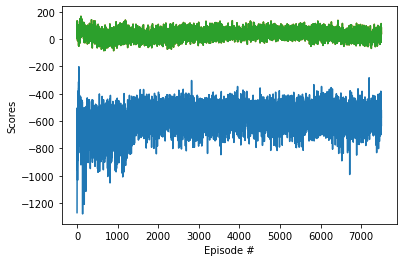

In [28]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, scores_mean.shape[0]+1), scores_mean)
plt.ylabel('Scores')
plt.xlabel('Episode #')
plt.show()

In [29]:
scores_acc_mean = scores_mean.mean(axis=1)

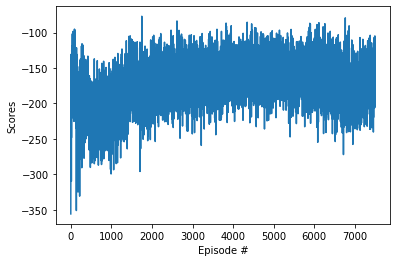

In [30]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores_acc_mean)+1), scores_acc_mean)
plt.ylabel('Scores')
plt.xlabel('Episode #')
plt.show()

```
while sleep 0.2; do
nvidia-smi --query-gpu=name,index,temperature.gpu,\
utilization.gpu,utilization.memory,\
memory.total,memory.free,memory.used --format=csv,noheader
done
```

```
GeForce GTX 1060, 0, 66, 8 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 8 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 10 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 8 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 10 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 10 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 8 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 11 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 10 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 9 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 10 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 9 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 9 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 8 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 10 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 8 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 10 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 11 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 7 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 10 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
GeForce GTX 1060, 0, 66, 7 %, 1 %, 6078 MiB, 5288 MiB, 790 MiB
```

In [31]:
saved_model = {'agent1_actor': agents[0].actor_local.state_dict(),
               'agent1_critic': agents[0].critic_local.state_dict(),
               'agent2_actor': agents[1].actor_local.state_dict(),
               'agent2_critic': agents[1].critic_local.state_dict(),
               'agent3_actor': agents[2].actor_local.state_dict(),
               'agent3_critic': agents[2].critic_local.state_dict()}

torch.save(saved_model, './models/saved_model.pth')

In [32]:
env.close()

## Agent in Action

In [30]:
def load_saved_model(filepath, device):
    saved_model = torch.load(filepath)
    
    # adversary, agent, agent
    agents = [Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE, 
                    random_seed=SEED, device=device),
              Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE, 
                    random_seed=SEED, device=device),
              Agent(state_size=STATE_SIZE, action_size=ACTION_SIZE, 
                    random_seed=SEED, device=device),]
    
    agents[0].actor_local.load_state_dict(saved_model['agent1_actor'])
    agents[0].actor_target.load_state_dict(saved_model['agent1_actor'])
    agents[0].critic_local.load_state_dict(saved_model['agent1_critic'])
    agents[0].critic_target.load_state_dict(saved_model['agent1_critic'])
    agents[1].actor_local.load_state_dict(saved_model['agent2_actor'])
    agents[1].actor_target.load_state_dict(saved_model['agent2_actor'])
    agents[1].critic_local.load_state_dict(saved_model['agent2_critic'])
    agents[1].critic_target.load_state_dict(saved_model['agent2_critic'])
    agents[2].actor_local.load_state_dict(saved_model['agent3_actor'])
    agents[2].actor_target.load_state_dict(saved_model['agent3_actor'])
    agents[2].critic_local.load_state_dict(saved_model['agent3_critic'])
    agents[2].critic_target.load_state_dict(saved_model['agent3_critic'])
    
    return agents

In [31]:
# check if CUDA is available
use_cuda = torch.cuda.is_available()
print("Use CUDA:",  use_cuda)

Use CUDA: True


In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [33]:
agents = load_saved_model('./models/saved_model.pth', device)
for agent in agents:
    agent.actor_local.eval()
    agent.critic_local.eval()